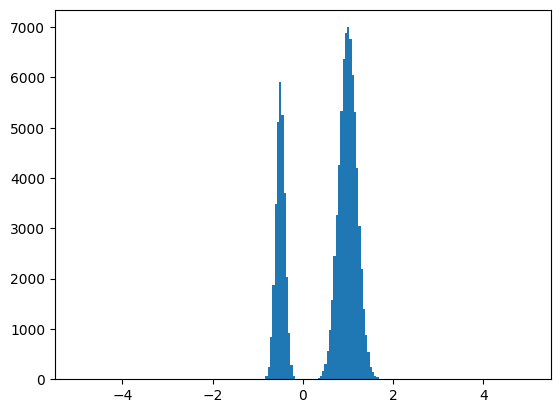

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.distributions as D

mixture = D.MixtureSameFamily(
    D.Categorical(torch.tensor([0.3, 0.7])),
    D.Normal(torch.tensor([-0.5, 1.0]), torch.tensor([0.1, 0.2])),
)
# target distribution
X = mixture.sample((100000, 1))

_ = plt.hist(X, bins=np.linspace(-5, 5, 200), label="data")

In [2]:
from typing import Callable, Iterable, Protocol, Self, Type

import torch
import torch.nn as nn
from tqdm.auto import tqdm

from flowmodels.basis import SamplingSupports
from flowmodels.cm import EMASupports


class Testbed(nn.Module, SamplingSupports):
    def __init__(self, dim: int = 1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, dim),
        )

    class _InheritanceSupports(SamplingSupports, Protocol):
        def loss(self, sample: torch.Tensor, t: torch.Tensor, src: torch.Tensor): ...
        def loss(
            self,
            sample: torch.Tensor,
            t: torch.Tensor,
            src: torch.Tensor,
            ema: EMASupports[Self],
        ): ...
        def loss(self, sample: torch.Tensor, t: torch.Tensor, prior: torch.Tensor): ...
        def loss(
            self,
            sample: torch.Tensor,
            t: torch.Tensor,
            prior: torch.Tensor,
            ema: EMASupports[Self],
        ): ...

    @classmethod
    def inherit[S: _InheritanceSupports](
        cls, Super: Type[S], dim: int = 1, retn_class: bool = False, *args, **kwargs
    ):
        class Inherited(cls):
            def __init__(self, dim: int = 1, *args, **kwargs):
                super().__init__(dim)
                self._super = (Super(self, *args, **kwargs),)

            @property
            def base(self) -> S:
                (_super,) = self._super
                return _super

            def loss(
                self,
                sample: torch.Tensor,
                t: torch.Tensor,
                src: torch.Tensor,
                ema: EMASupports | None = None,
            ):
                if ema is None:
                    return self.base.loss(sample, t, src)
                return self.base.loss(sample, t, src, ema)

            def sample(
                self,
                prior: torch.Tensor,
                steps: int | None = None,
                verbose: Callable[[range], Iterable] | None = None,
            ):
                return self.base.sample(prior, steps, verbose)

        if retn_class:
            return Inherited
        return Inherited(dim, *args, **kwargs)

    def forward(self, x_t: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        return self.net.forward(torch.cat([x_t, t[:, None].to(x_t)], dim=-1))

    def loss(
        self,
        sample: torch.Tensor,
        t: torch.Tensor,
        src: torch.Tensor,
        ema: EMASupports[Self] | None = None,
    ) -> torch.Tensor: ...

    def train_loop(
        self,
        dataset: torch.Tensor | tuple[torch.Tensor, torch.Tensor],
        lr: float = 0.001,
        train_steps: int = 1000,
        batch_size: int = 2048,
        optim: Type[torch.optim.Optimizer] | torch.optim.Optimizer = torch.optim.Adam,
        mu: float = 0.0,
        ema: EMASupports[Self] | None = None,
    ) -> list[float]:
        # train
        self.train()
        if isinstance(optim, type):
            optim = optim(self.parameters(), lr)

        losses = []
        with tqdm(range(train_steps)) as pbar:
            for i in pbar:
                indices = torch.randint(0, len(X), (batch_size,))
                if isinstance(dataset, torch.Tensor):
                    sample = dataset[indices]
                    prior = torch.randn_like(sample)
                else:
                    _data, _prior = dataset
                    sample, prior = _data[indices], _prior[indices]
                # []
                loss = self.loss(sample, torch.rand(batch_size), prior, ema)
                # update
                optim.zero_grad()
                loss.backward()
                optim.step()

                if ema is not None:
                    ema.update(self, mu=mu)

                # log
                loss = loss.detach().item()
                losses.append(loss)
                pbar.set_postfix_str(f"loss: {loss:.2f}")

        return losses

    def visualize(
        self,
        name: str,
        losses: list[float],
        gt: torch.Tensor,
        prior: torch.Tensor | None = None,
        steps: list[int] = [100, 4, 1],
        n: int = 10000,
        histspace: torch.Tensor = torch.linspace(-3, 3, 200),
        trajspace: torch.Tensor = torch.linspace(-3, 3, 10)[:, None],
        verbose: Callable[[range], Iterable] | None = None,
        _sigma_data: float = 1.0,
    ):
        plt.plot(losses)

        # plot histogram
        if prior is None:
            prior = torch.randn(n, *gt.shape[1:])
        with torch.inference_mode():
            x_ts = [
                x_t for step in steps for x_t, _ in (self.sample(prior, step, verbose),)
            ]
        plt.figure()
        plt.hist(prior, bins=histspace, label="prior")
        plt.hist(gt[:n], bins=histspace, label="gt", alpha=0.7)
        for step, x_t in zip(steps, x_ts):
            plt.hist(x_t.view(-1), bins=histspace, label=f"{name}-{step}", alpha=0.5)
        plt.legend()
        _xticks, _ = plt.xticks()

        # plt.trajectory
        with torch.inference_mode():
            x_trajs = [
                x_ts
                for step in steps
                for _, x_ts in (self.sample(trajspace, step, verbose),)
            ]
        plt.figure()
        colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
        for i in range(len(trajspace)):
            for j, (step, x_ts) in enumerate(zip(steps, x_trajs)):
                plt.plot(
                    torch.tensor(
                        [_sigma_data * trajspace[i].item()]
                        + [x_t[i].item() for x_t in x_ts]
                    ),
                    np.linspace(0, 1, len(x_ts) + 1),
                    colors[j % len(colors)],
                    **({} if i > 0 else {"label": f"{name}-{step}"}),
                    alpha=0.5,
                )
                plt.xticks(_xticks)
        plt.legend()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

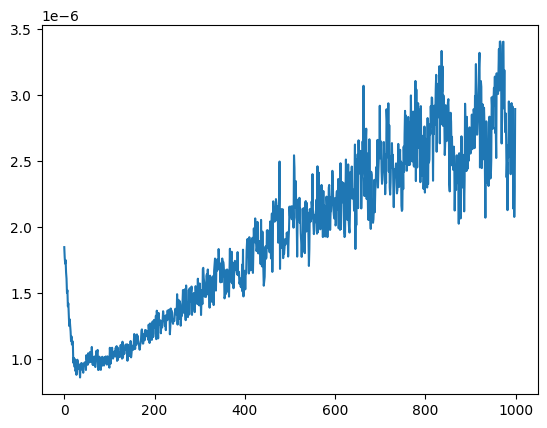

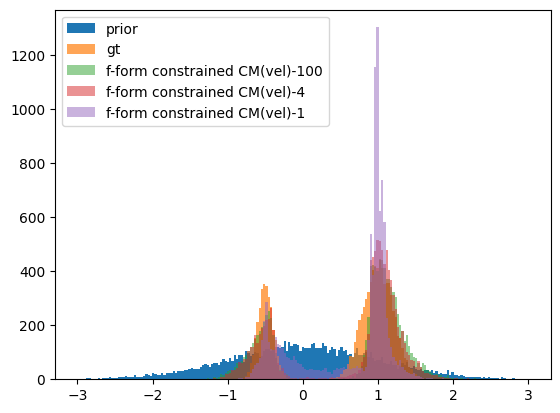

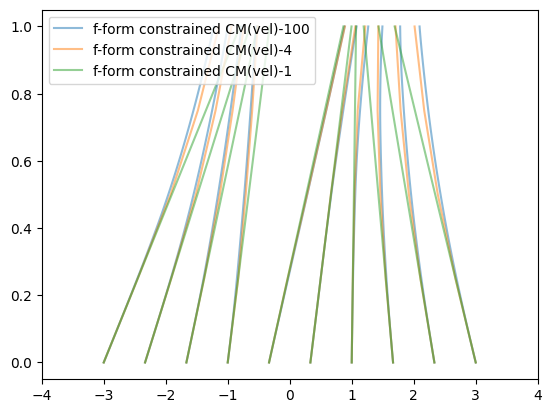

In [3]:
# Case#1. f-form constrained CM
from flowmodels import ConsistencyFlowMatching


class TestbedConsistencyFMLikeFormConstrainedCM(
    Testbed.inherit(ConsistencyFlowMatching, retn_class=True)
):
    def loss(
        self,
        sample: torch.Tensor,
        t: torch.Tensor,
        src: torch.Tensor,
        ema: EMASupports[Self] | None = None,
        delta_t: float = 1e-3,
    ) -> torch.Tensor:
        batch_size, *_ = sample.shape
        # reduce to the Consistency FM
        ema = EMASupports[Self].reduce(self, ema)
        # compute objective
        backup = t
        # [B, ...]
        t = t.view([batch_size] + [1] * (sample.dim() - 1))
        # [B, ...]
        x_t = t * sample + (1 - t) * src
        x_td = ((t + delta_t) * sample) + (1 - t - delta_t) * src
        # [B, ...]
        estim = self.forward(x_t, backup)
        with torch.inference_mode():
            estim_ema = ema.forward(x_td, backup + delta_t)
        # [], estimated endpoint
        estim = x_t + (1 - t) * estim
        estim_ema = x_td + (1 - t - delta_t) * estim_ema
        # [], velocity consistency
        consistency = (estim - estim_ema).square().mean()
        return consistency


model = TestbedConsistencyFMLikeFormConstrainedCM()
losses = model.train_loop(
    X,
    lr=0.001,
    train_steps=1000,
    batch_size=2048,
    optim=torch.optim.Adam,
    mu=0.0,
    ema=EMASupports(model),
)
model.visualize(
    "f-form constrained CM(vel)",
    losses,
    gt=X,
    prior=None,
    n=10000,
    verbose=lambda x: tqdm(x, leave=False),
)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

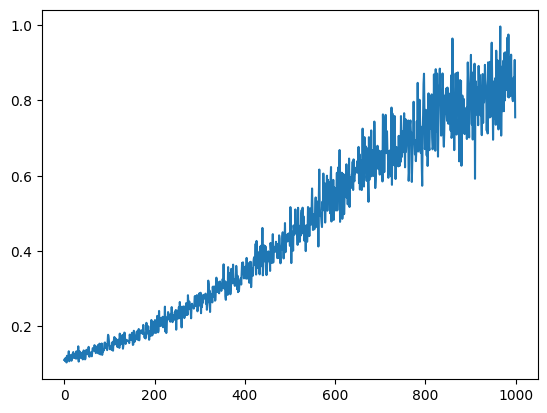

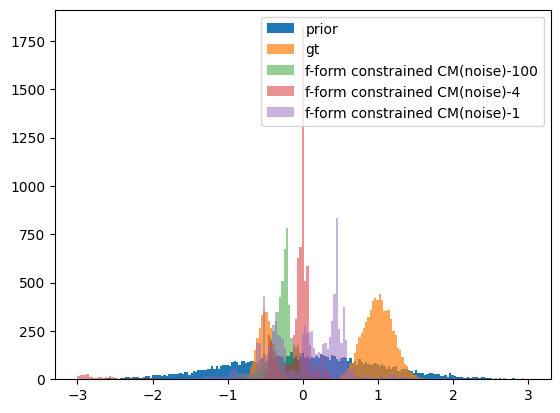

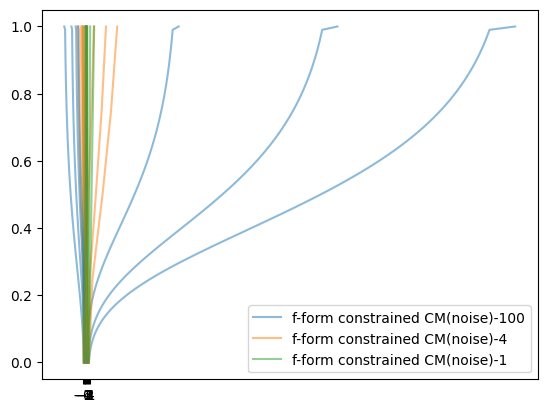

In [4]:
# Case#1.a. f-form constrained with noise estimator
from flowmodels import VESDEScheduler, MultistepConsistencySampler
from flowmodels.basis import ScoreSupports


class TestbedConsistencyFMLikeFormConstrainedNoisePredCM(Testbed, ScoreSupports):
    def __init__(self, dim: int = 1, scheduler: VESDEScheduler = None):
        super().__init__(dim)
        self.scheduler = scheduler
        self.sampler = MultistepConsistencySampler(self.scheduler)

    def score(self, x_t: torch.Tensor, t: torch.Tensor):
        (bsize,) = t.shape
        noise = self.forward(x_t, t)
        v_t = self.scheduler.var(t)
        v_t = v_t.view([bsize] + [1] * (noise.dim() - 1))
        return -noise * v_t.clamp_min(1e-7).rsqrt().to(x_t)

    def sample(
        self,
        prior: torch.Tensor,
        steps: int | None = None,
        verbose: Callable[[range], Iterable] | None = None,
    ):
        return self.sampler.sample(self, prior, steps, verbose)

    def loss(
        self,
        sample: torch.Tensor,
        t: torch.Tensor,
        src: torch.Tensor,
        ema: EMASupports[Self] | None = None,
        # delta_t: float = 1e-3,
    ) -> torch.Tensor:
        batch_size, *_ = sample.shape
        # reduce to the Consistency FM
        ema = EMASupports[Self].reduce(self, ema)
        # compute objective
        backup = t
        # [B, ...]
        delta_t = torch.rand_like(t) * (1 - t)
        # [B, ...]
        t = t.view([batch_size] + [1] * (sample.dim() - 1))
        # [B, ...]
        v_t, v_td = self.scheduler.var(t), self.scheduler.var(
            t + delta_t.view([batch_size] + [1] * (sample.dim() - 1))
        )
        # [B, ...]
        x_t = sample + v_t.sqrt() * src
        x_td = sample + v_td.sqrt() * src
        # [B, ...]
        estim = self.forward(x_t, backup)
        with torch.inference_mode():
            estim_ema = ema.forward(x_td, backup + delta_t)
        # [], estimated endpoint
        estim = x_t - v_t.sqrt() * estim
        estim_ema = x_td - v_td.sqrt() * estim_ema
        # [], velocity consistency
        consistency = (estim - estim_ema).square().mean()
        return consistency


model = TestbedConsistencyFMLikeFormConstrainedNoisePredCM(scheduler=VESDEScheduler())
losses = model.train_loop(
    X,
    lr=0.001,
    train_steps=1000,
    batch_size=2048,
    optim=torch.optim.Adam,
    mu=0.99,
    ema=EMASupports(model),
)
model.visualize(
    "f-form constrained CM(noise)",
    losses,
    gt=X,
    prior=None,
    n=10000,
    verbose=lambda x: tqdm(x, leave=False),
)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

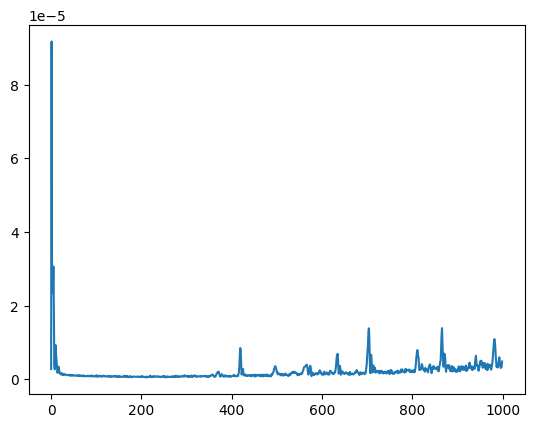

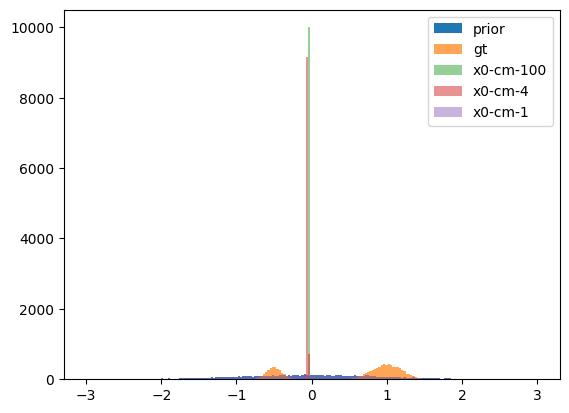

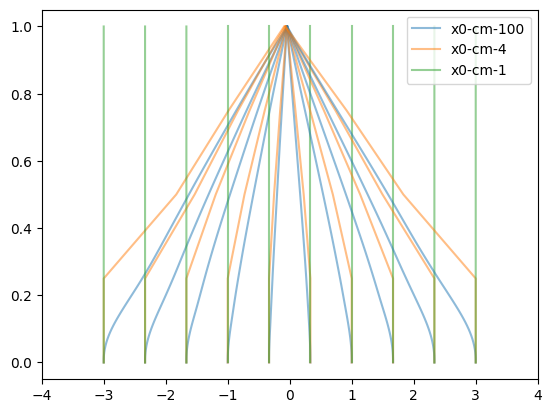

In [5]:
# Case#1.b. f-form constrained with residual connection (from ConsistencyFM-like objective omitting df)
from flowmodels import VanillaEulerSolver
from flowmodels.basis import VelocitySupports


class TestbedConsistencyFMLikeX0ConstrainedCM(Testbed, VelocitySupports):
    def __init__(self, dim: int = 1):
        super().__init__(dim=dim)
        self.sampler = VanillaEulerSolver()

    def forward(self, x_t: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        (bsize,) = t.shape
        x_0 = super().forward(x_t, t)
        t = t.view([bsize] + [1] * (x_t.dim() - 1))
        return (
            0.025 / ((t - 1e-7).square() + 0.025) * x_t
            + 0.5 * (t - 1e-7) * (0.025 + t.square()).clamp_min(1e-7).rsqrt() * x_0
        )

    def velocity(self, x_t: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        (bsize,) = t.shape
        return (self.forward(x_t, t) - x_t) / (
            1 - t.view([bsize] + [1] * (x_t.dim() - 1))
        )

    def sample(
        self,
        prior: torch.Tensor,
        steps: int | None = None,
        verbose: Callable[[range], Iterable] | None = None,
    ):
        return self.sampler.solve(self, prior, steps, verbose)

    def loss(
        self,
        sample: torch.Tensor,
        t: torch.Tensor,
        src: torch.Tensor,
        ema: EMASupports[Self] | None = None,
        delta_t: float = 1e-3,
    ) -> torch.Tensor:
        batch_size, *_ = sample.shape
        # reduce to the Consistency FM
        ema = EMASupports[Self].reduce(self, ema)
        # compute objective
        backup = t
        # [B, ...]
        t = t.view([batch_size] + [1] * (sample.dim() - 1))
        # [B, ...]
        x_t = t * sample + (1 - t) * src
        x_td = ((t + delta_t) * sample) + (1 - t - delta_t) * src
        # [B, ...]
        estim = self.forward(x_t, backup)
        with torch.inference_mode():
            estim_ema = ema.forward(x_td, backup + delta_t)
        # [], velocity consistency
        consistency = (estim - estim_ema.detach()).square().mean()
        return consistency


model = TestbedConsistencyFMLikeX0ConstrainedCM()
losses = model.train_loop(
    X,
    lr=0.001,
    train_steps=1000,
    batch_size=2048,
    optim=torch.optim.Adam,
    mu=0.9,
    ema=EMASupports(model),
)
model.visualize(
    "x0-cm",
    losses,
    gt=X,
    prior=None,
    n=10000,
    verbose=lambda x: tqdm(x, leave=False),
)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

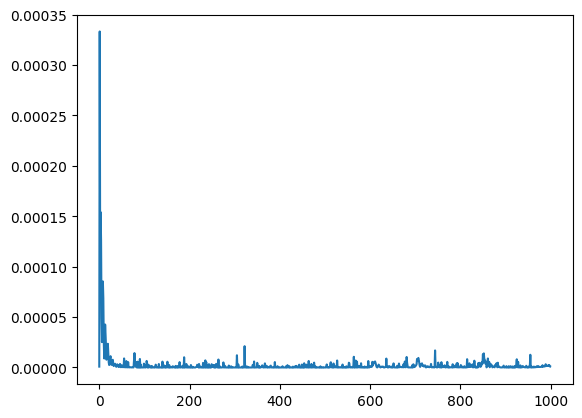

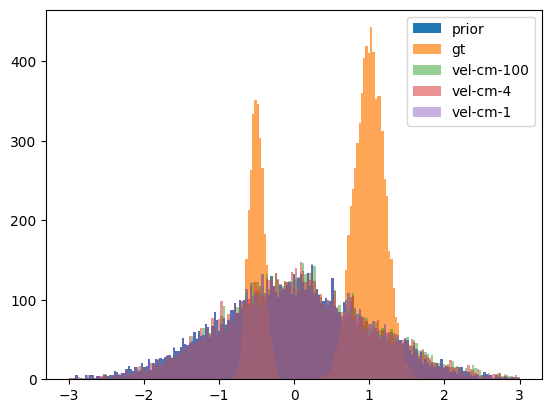

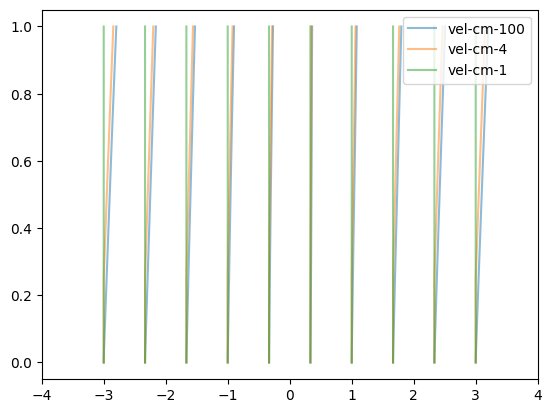

In [6]:
# Case#2. velocity consistency
from flowmodels import VanillaEulerSolver
from flowmodels.basis import VelocitySupports


class TestbedConsistencyFMLikeVelocityCM(Testbed):
    def __init__(self, dim: int = 1):
        super().__init__(dim)
        self.solver = VanillaEulerSolver()

    def forward(self, x_t: torch.Tensor, t: torch.Tensor):
        (bsize,) = t.shape
        velocity = super().forward(x_t, t)
        t = t.view([bsize] + [1] * (x_t.dim() - 1))
        return (t - 1e-7) * t.square().clamp_min(1e-7).rsqrt() * velocity

    def velocity(self, x_t: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        return self.forward(x_t, t)

    def sample(
        self,
        prior: torch.Tensor,
        steps: int | None = 1,
        verbose: Callable[[range], Iterable] | None = None,
    ) -> tuple[torch.Tensor, list[torch.Tensor]]:
        return self.solver.solve(self, prior, steps, verbose)

    def loss(
        self,
        sample: torch.Tensor,
        t: torch.Tensor,
        src: torch.Tensor,
        ema: EMASupports[Self] | None = None,
        delta_t: float = 1e-3,
    ) -> torch.Tensor:
        batch_size, *_ = sample.shape
        # reduce to the Consistency FM
        ema = EMASupports[Self].reduce(self, ema)
        # compute objective
        backup = t
        # [B, ...]
        t = t.view([batch_size] + [1] * (sample.dim() - 1))
        # [B, ...]
        x_t = t * sample + (1 - t) * src
        x_td = ((t + delta_t) * sample) + (1 - t - delta_t) * src
        # [B, ...]
        estim = self.forward(x_t, backup)
        with torch.inference_mode():
            estim_ema = ema.forward(x_td, backup + delta_t)
        # [], velocity consistency
        consistency = (estim - estim_ema.detach()).square().mean()
        return consistency


model = TestbedConsistencyFMLikeVelocityCM()
losses = model.train_loop(
    X,
    lr=0.001,
    train_steps=1000,
    batch_size=2048,
    optim=torch.optim.Adam,
    mu=0.99,
    ema=EMASupports(model),
)
model.visualize(
    "vel-cm",
    losses,
    gt=X,
    prior=None,
    n=10000,
    verbose=lambda x: tqdm(x, leave=False),
)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

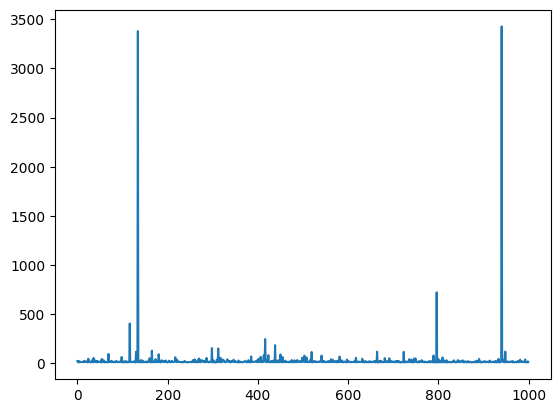

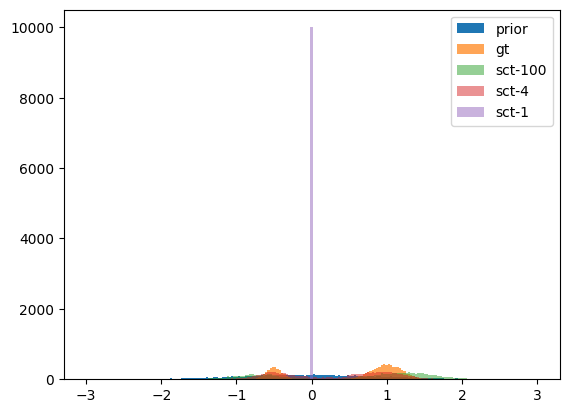

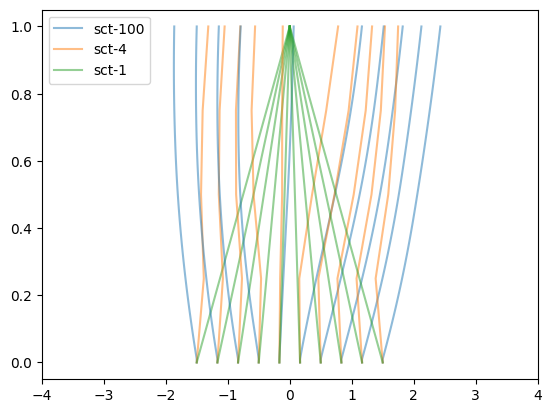

In [7]:
# Case#2.a. consistency model
from flowmodels.sct import ScaledContinuousCM, ScaledContinuousCMScheduler


class TestbedSCT(Testbed.inherit(ScaledContinuousCM, retn_class=True)):
    @property
    def F0(self) -> nn.Module:
        return self.base.F0


model = TestbedSCT(scheduler=ScaledContinuousCMScheduler())
losses = model.train_loop(
    X,
    lr=0.001,
    train_steps=1000,
    batch_size=2048,
    optim=torch.optim.Adam,
    mu=0.0,
    ema=EMASupports(model),
)
model.visualize(
    "sct",
    losses,
    gt=X,
    prior=None,
    n=10000,
    verbose=lambda x: tqdm(x, leave=False),
    _sigma_data=model.base.scheduler.sigma_d,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

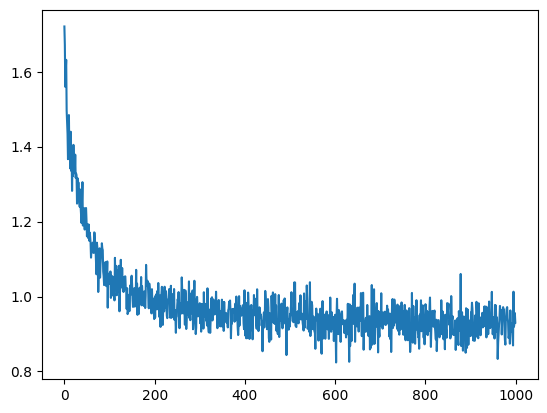

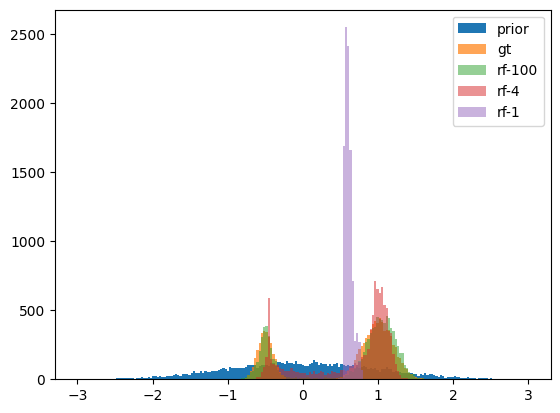

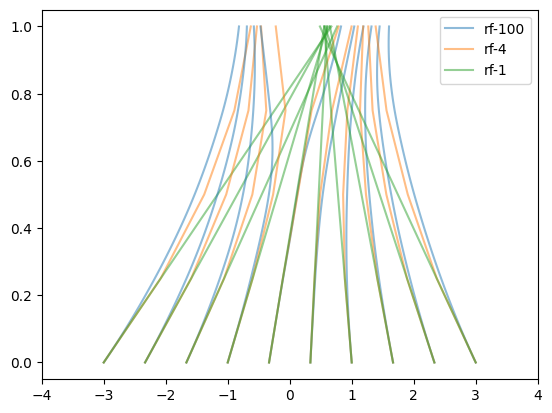

In [8]:
# Case#3. rectified flow
from flowmodels.rf import RectifiedFlow


model = Testbed.inherit(RectifiedFlow)
losses = model.train_loop(
    X,
    lr=0.001,
    train_steps=1000,
    batch_size=2048,
    optim=torch.optim.Adam,
)
model.visualize(
    "rf",
    losses,
    gt=X,
    prior=None,
    n=10000,
    verbose=lambda x: tqdm(x, leave=False),
)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

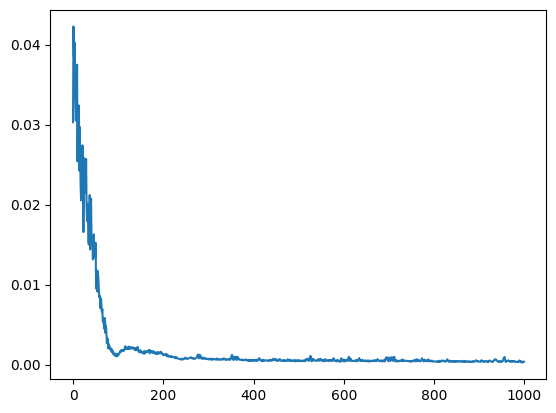

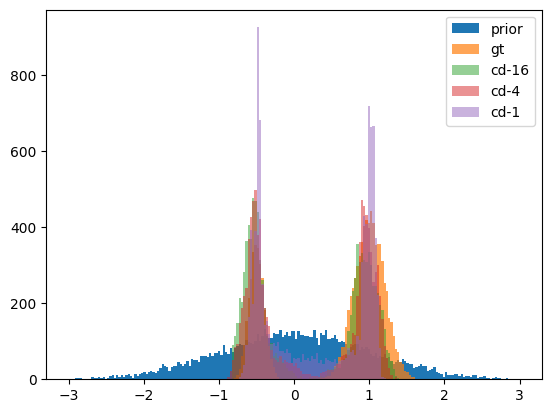

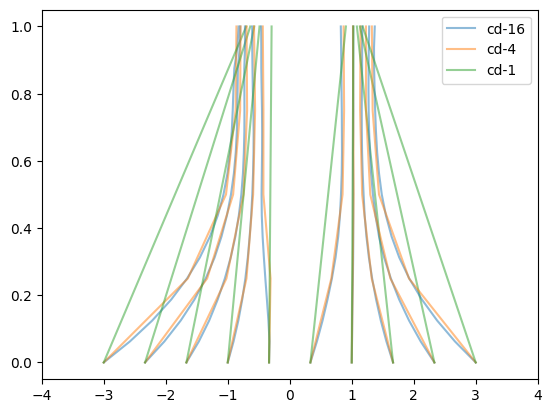

In [9]:
# Case#3.a.i Consistency Distillation
from flowmodels import VESDE, VESDEScheduler, ProbabilityFlowODESampler
from flowmodels import ConsistencyModel, ConsistencyModelScheduler


teacher = Testbed.inherit(VESDE, scheduler=VESDEScheduler())
teacher.base.sampler = ProbabilityFlowODESampler(teacher.base.scheduler)
losses = teacher.train_loop(
    X,
    lr=0.001,
    train_steps=1000,
    batch_size=2048,
    optim=torch.optim.Adam,
)

cd = Testbed.inherit(ConsistencyModel, scheduler=ConsistencyModelScheduler(T=16))
losses, _ = cd.base.distillation(
    teacher.base,
    torch.optim.Adam(cd.parameters(), lr=0.001),
    training_steps=1000,
    batch_size=2048,
    sample=X,
    mu=0.9,
    verbose=lambda r: tqdm(r, leave=False),
)
cd.visualize("cd", losses, gt=X, prior=None, steps=[16, 4, 1], n=10000)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

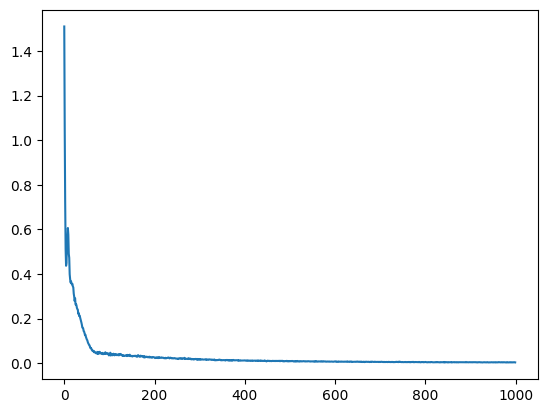

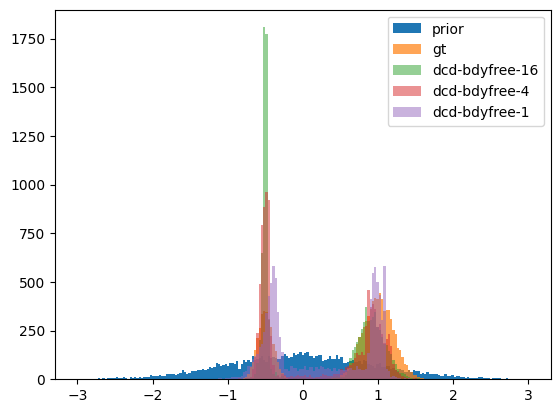

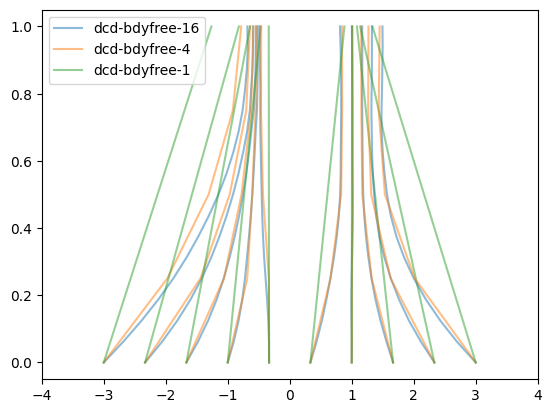

In [10]:
# Case#3.a.ii Direct CD w/o boundary condition
import torch.nn.functional as F
from flowmodels import VESDE, VESDEScheduler, ProbabilityFlowODESampler
from flowmodels import (
    ConsistencyModelScheduler,
    MultistepConsistencySampler,
)


teacher = Testbed.inherit(VESDE, scheduler=VESDEScheduler())
teacher.base.sampler = ProbabilityFlowODESampler(teacher.base.scheduler)
losses = teacher.train_loop(
    X,
    lr=0.001,
    train_steps=1000,
    batch_size=2048,
    optim=torch.optim.Adam,
)


class TestbedDirectCD(Testbed):
    def __init__(self, dim: int = 1, scheduler: ConsistencyModelScheduler = None):
        super().__init__(dim)
        self.scheduler = scheduler
        self.sampler = MultistepConsistencySampler(scheduler)
        # prepare the sampler
        self._teacher_sampler = MultistepConsistencySampler(teacher.base.scheduler)
        # [T + 1]
        self._var = F.pad(self.scheduler.var(), [1, 0], "constant", self.scheduler.eps)

    def score(self, x_t: torch.Tensor, t: torch.Tensor):
        # discretize in range[0, T]
        t = (t * self.scheduler.T).long()
        # [B, ...]
        x_0 = self.forward(x_t, t)
        # [T + 1, ...]
        var = F.pad(self.scheduler.var(), [1, 0], "constant", 1e-7).view(
            [self.scheduler.T + 1] + [1] * (x_0.dim() - 1)
        )
        return (x_0 - x_t) / var[t].to(x_0).clamp_min(1e-7)

    def sample(
        self,
        prior: torch.Tensor,
        steps: int | None = None,
        verbose: Callable[[range], Iterable] | None = None,
    ):
        return self.sampler.sample(self, prior, steps, verbose)

    def loss(
        self,
        sample: torch.Tensor,
        t: torch.Tensor,
        prior: torch.Tensor,
        ema: EMASupports | None = None,
    ) -> torch.Tensor:
        (batch_size,) = t.shape
        # [B]
        t = (t * self.scheduler.T).long() + 1
        # noising
        x_t: torch.Tensor
        v_t_view = self._var[t].view([batch_size] + [1] * (sample.dim() - 1))
        if self.scheduler.vp:
            x_t = (1 - v_t_view).sqrt() * sample + v_t_view.sqrt() * prior
        else:
            x_t = sample + v_t_view.sqrt() * prior
        with torch.inference_mode():
            _x_t = prior
            for _t in range(self.scheduler.T, 0, -1):
                _x_t[t == _t] = x_t[t == _t]
                _t = torch.full((batch_size,), _t, dtype=torch.long)
                _x_t = self._teacher_sampler._denoise(
                    teacher.base,
                    _x_t,
                    _t / self.scheduler.T,
                    self._var[_t],
                    self._var[_t - 1],
                )
            gt = _x_t
        # [B, ...]
        x_0 = self.forward(x_t, t)  # do not work on `x_0 = self.forward(x_t, t)`
        # []
        return (x_0 - gt.detach()).square().mean()


directcd = TestbedDirectCD(scheduler=ConsistencyModelScheduler(T=16))
losses = directcd.train_loop(
    X,
    lr=0.001,
    train_steps=1000,
    batch_size=2048,
    optim=torch.optim.Adam,
)
directcd.visualize(
    "dcd-bdyfree",
    losses,
    gt=X,
    prior=None,
    steps=[16, 4, 1],
    n=10000,
    verbose=lambda x: tqdm(x, leave=False),
)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

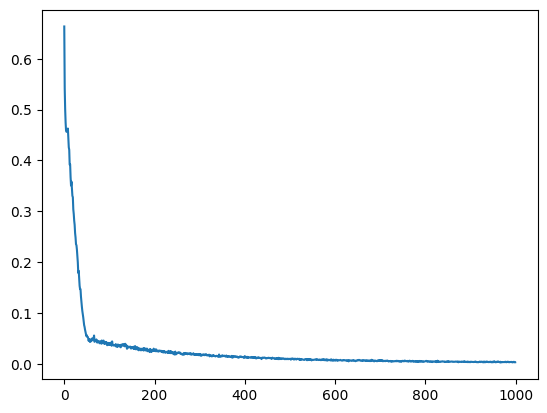

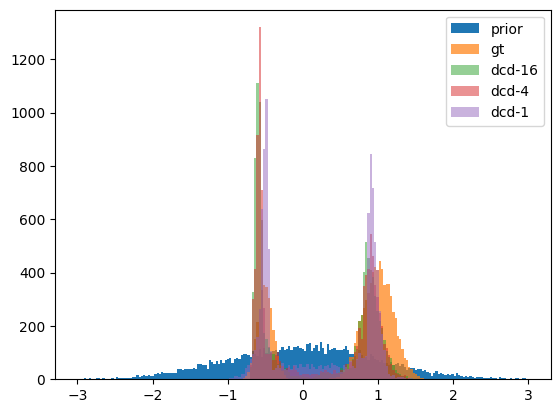

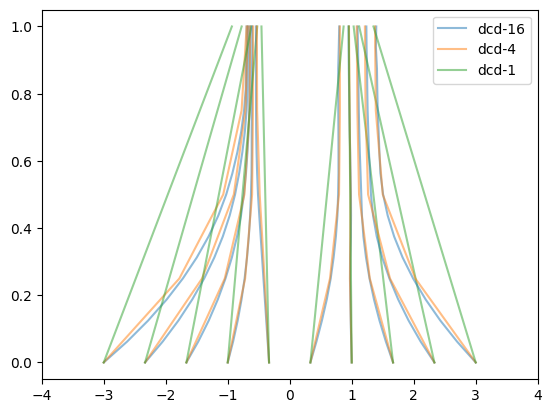

In [11]:
# Case#3.a.ii Direct CD
import torch.nn.functional as F
from flowmodels import VESDE, VESDEScheduler, ProbabilityFlowODESampler
from flowmodels import (
    ConsistencyModel,
    ConsistencyModelScheduler,
    MultistepConsistencySampler,
)


teacher = Testbed.inherit(VESDE, scheduler=VESDEScheduler())
teacher.base.sampler = ProbabilityFlowODESampler(teacher.base.scheduler)
losses = teacher.train_loop(
    X,
    lr=0.001,
    train_steps=1000,
    batch_size=2048,
    optim=torch.optim.Adam,
)


class TestbedFormConstrainedDirectCD(
    Testbed.inherit(ConsistencyModel, retn_class=True)
):
    def __init__(self, dim: int = 1, *args, **kwargs):
        super().__init__(dim, *args, **kwargs)
        # prepare the sampler
        self._teacher_sampler = MultistepConsistencySampler(teacher.base.scheduler)
        # [T + 1]
        self._var = F.pad(
            self.base.scheduler.var(), [1, 0], "constant", self.base.scheduler.eps
        )
        self._debugs = []

    def loss(
        self,
        sample: torch.Tensor,
        t: torch.Tensor,
        prior: torch.Tensor,
        ema: EMASupports | None = None,
    ) -> torch.Tensor:
        (batch_size,) = t.shape
        # [B]
        t = (t * self.base.scheduler.T).long() + 1
        # noising
        x_t: torch.Tensor
        v_t_view = self._var[t].view([batch_size] + [1] * (sample.dim() - 1))
        if self.base.scheduler.vp:
            x_t = (1 - v_t_view).sqrt() * sample + v_t_view.sqrt() * prior
        else:
            x_t = sample + v_t_view.sqrt() * prior
        with torch.inference_mode():
            _x_t = prior
            for _t in range(self.base.scheduler.T, 0, -1):
                _x_t[t == _t] = x_t[t == _t]
                _t = torch.full((batch_size,), _t, dtype=torch.long)
                _x_t = self._teacher_sampler._denoise(
                    teacher.base,
                    _x_t,
                    _t / self.base.scheduler.T,
                    self._var[_t],
                    self._var[_t - 1],
                )
            gt = _x_t
            self._debugs.append(gt)
        # [B, ...]
        x_0 = self.base.forward(x_t, t)  # do not work on `x_0 = self.forward(x_t, t)`
        # []
        return (x_0 - gt.detach()).square().mean()


directcd = TestbedFormConstrainedDirectCD(scheduler=ConsistencyModelScheduler(T=16))
losses = directcd.train_loop(
    X,
    lr=0.001,
    train_steps=1000,
    batch_size=2048,
    optim=torch.optim.Adam,
)
directcd.visualize(
    "dcd",
    losses,
    gt=X,
    prior=None,
    steps=[16, 4, 1],
    n=10000,
    verbose=lambda x: tqdm(x, leave=False),
)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

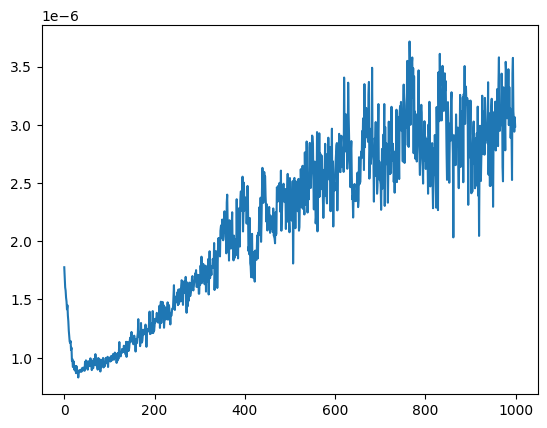

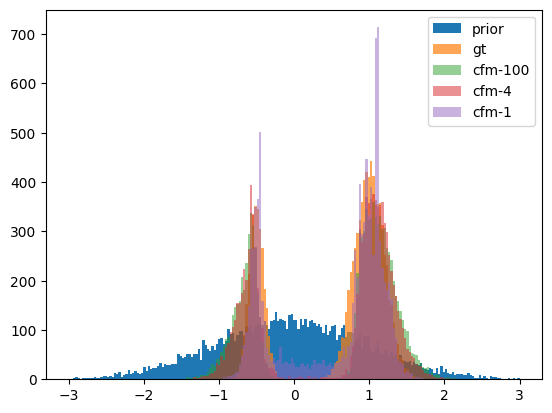

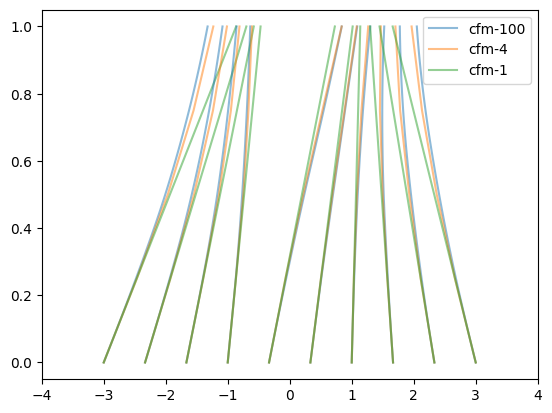

In [12]:
# Case#4. consistency flow matching
from flowmodels.consistencyfm import ConsistencyFlowMatching


model = Testbed.inherit(ConsistencyFlowMatching)
losses = model.train_loop(
    X,
    lr=0.001,
    train_steps=1000,
    batch_size=2048,
    optim=torch.optim.Adam,
    mu=0.0,
    ema=EMASupports(model),
)
model.visualize(
    "cfm",
    losses,
    gt=X,
    prior=None,
    n=10000,
    verbose=lambda x: tqdm(x, leave=False),
)